<a href="https://colab.research.google.com/github/AI4GoodProject/speechRecForMeeting/blob/master/CNNModelWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2,glob
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'torch'

0.Data retrieving/some preprocessing


In [2]:
# Load the Drive helper and mount
from google.colab import drive
import pickle

# This will prompt for authorization.
drive.mount('/content/drive')

DATA_PATH = "/content/drive/My Drive/Team 6/processed-data"

Mounted at /content/drive


In [43]:
features= open(DATA_PATH+'/features-10M.pkl','rb')
labels= open(DATA_PATH+'/labels-10M.pkl','rb')
features_list = pickle.load(features)
features_list = features_list#[:3780]
labels_list = pickle.load(labels)
labels_list = labels_list#[:3780]

#labels_list = [random.randint(0,1) for _ in range(len(features_list))]

print("features_list","\n. eg", features_list[:1])
print("length", len(features_list)) 
print("width", len(features_list[0]))
print(type(features_list))
print(type(features_list[0]),"shape",features_list[0].shape)
print(type(features_list[0][0]),"shape",features_list[0][0].shape)
print("-----------------")
print("labels_list","\n",labels_list[:1])
print("length", len(labels_list)) 
print("peek", labels_list[0])
print(type(labels_list))
print(type(labels_list[0]))

features_list 
. eg tensor([[[[2.0803e-02, 2.0335e-01, 1.9791e-01,  ..., 4.5398e-03,
           6.4138e-03, 9.7432e-04],
          [3.8635e-02, 3.7764e-01, 3.6756e-01,  ..., 8.4310e-03,
           1.1911e-02, 1.8094e-03],
          [2.4055e-02, 3.3172e-01, 2.5881e-01,  ..., 3.7214e-02,
           6.7238e-02, 8.2930e-02],
          ...,
          [1.9897e-02, 8.3690e-03, 1.5399e-04,  ..., 9.7631e-05,
           1.5120e-04, 8.3749e-03],
          [2.7316e-04, 4.3446e-03, 4.4164e-04,  ..., 3.0579e-04,
           2.3322e-04, 3.6309e-03],
          [1.4709e-04, 2.3394e-03, 2.3781e-04,  ..., 1.6466e-04,
           1.2558e-04, 1.9551e-03]]]])
length 3780
width 1
<class 'torch.Tensor'>
<class 'torch.Tensor'> shape torch.Size([1, 32, 401])
<class 'torch.Tensor'> shape torch.Size([32, 401])
-----------------
labels_list 
 [0]
length 3780
peek 0
<class 'list'>
<class 'int'>


In [4]:
def crossJoin (list1,list2):
  crossJoined_list = []
  
  for i in range(0,len(list1)):
    inner_list = []
    for j in range(0,1):
      inner_list.append(list1[i])
      inner_list.append(list2[i])
    crossJoined_list.append(inner_list)

  return crossJoined_list

**1. Train/validate/test split**

In [51]:

X_train,X_test,Y_train,Y_test = train_test_split(features_list, labels_list, test_size=0.3, train_size=0.7, random_state=1, shuffle=True)

X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=1)


In [52]:
from torch.utils.data import WeightedRandomSampler
from collections import Counter

count=Counter(Y_train)
class_count=np.array([count[0],count[1]])
print("0:1 Interruption Ratio - ", count[0],":",count[1])
weight=1./class_count
print("Weight:", weight)

samples_weight = np.array([weight[t] for t in Y_train])
samples_weight = torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
print("Sampler loaded.")

0:1 Interruption Ratio -  2641 : 5
Weight: [0.00037864 0.2       ]
Sampler loaded.


In [53]:
count_val=Counter(Y_val)
class_count_val=np.array([count_val[0],count_val[1]])
print("0:1 Interruption Ratio - ", count_val[0],":",count_val[1])
weight_val=1./class_count_val
print("Weight:", weight_val)

samples_weight_val = np.array([weight_val[t] for t in Y_val])
samples_weight_val = torch.from_numpy(samples_weight_val)

sampler_val = WeightedRandomSampler(samples_weight_val, len(samples_weight_val))
print("Validated sampler loaded.")

0:1 Interruption Ratio -  565 : 2
Weight: [0.00176991 0.5       ]
Validated sampler loaded.


In [60]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 6, 2, stride=2)
        self.conv3 = nn.Conv2d(6, 6, 2, stride=2)
        self.fc1 = nn.Linear(72, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [61]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True )

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [12]:
use_gpu = torch.cuda.is_available()

2.Training

In [13]:
def prediction(loader, model):

  correct = 0
  total = 0
  losses = 0

  for i, (images, labels) in enumerate(loader):
    if use_gpu:
      # switch tensor type to GPU
      images = images.cuda()
      labels = labels.cuda()
      
      
    #print(image.shape, 'test')
    outputs = model(images)
    
    loss = criterion(outputs, labels)
  
    _, predictions = torch.max(outputs, 1)
  
    correct += torch.sum(labels == predictions).item()
    total += labels.shape[0]
    
    losses += loss.data.item()
    
  return losses/len(list(loader)), 1 - correct/total # we need to normalize loss with respect to the number of batches 

In [62]:
CNN = CNN()

#evaluation
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN.parameters(), lr=0.01, momentum=0.9)

train_losses = []
test_losses = []

train_error_rates = []
test_error_rates = []


if use_gpu:
  # switch model to GPU
  CNN.cuda()

num_epochs = 15

for epoch in range(num_epochs): 
  train_loss = 0 
  n_iter = 0 
  total = 0
  correct = 0

  for i, (images, labels) in enumerate(train_dataloader): 
    optimizer.zero_grad() 

    if use_gpu: 
      images = images.cuda()
      labels = labels.cuda()

    #print(images.shape, 'train')
    outputs = CNN(images)
    
    # to compute the train_error_rates  
    _, predictions = torch.max(outputs, 1)
    correct += torch.sum(labels == predictions).item()
    total += labels.shape[0]
    
    # compute loss
    #print(outputs.shape)
    #print(labels.shape)
    #print(labels) 
    loss_bs = criterion(outputs, labels)
    # compute gradients
    loss_bs.backward()
    # update weights
    optimizer.step()

    train_loss += loss_bs.detach().item()

    n_iter += 1

  train_error_rate = 1 - correct/total

  with torch.no_grad():
    test_loss, test_error_rate = prediction(val_dataloader, CNN)

  train_error_rates.append(train_error_rate)
  test_error_rates.append(test_error_rate)
  train_losses.append(train_loss/n_iter)
  test_losses.append(test_loss)

  if epoch%1 == 0:
    print('Epoch: {}/{}, Loss: {:.4f}, Error Rate: {:.1f}%'.format(epoch+1, num_epochs, train_loss/n_iter, 100*train_error_rate))

Epoch: 1/15, Loss: 0.1720, Error Rate: 6.4%
Epoch: 2/15, Loss: 0.0368, Error Rate: 0.2%
Epoch: 3/15, Loss: 0.0191, Error Rate: 0.2%
Epoch: 4/15, Loss: 0.0147, Error Rate: 0.2%
Epoch: 5/15, Loss: 0.0129, Error Rate: 0.2%
Epoch: 6/15, Loss: 0.0119, Error Rate: 0.2%
Epoch: 7/15, Loss: 0.0113, Error Rate: 0.2%
Epoch: 8/15, Loss: 0.0107, Error Rate: 0.2%
Epoch: 9/15, Loss: 0.0103, Error Rate: 0.2%
Epoch: 10/15, Loss: 0.0101, Error Rate: 0.2%
Epoch: 11/15, Loss: 0.0097, Error Rate: 0.2%
Epoch: 12/15, Loss: 0.0094, Error Rate: 0.2%
Epoch: 13/15, Loss: 0.0092, Error Rate: 0.2%
Epoch: 14/15, Loss: 0.0089, Error Rate: 0.2%
Epoch: 15/15, Loss: 0.0087, Error Rate: 0.2%


In [57]:
from matplotlib import pyplot as plt


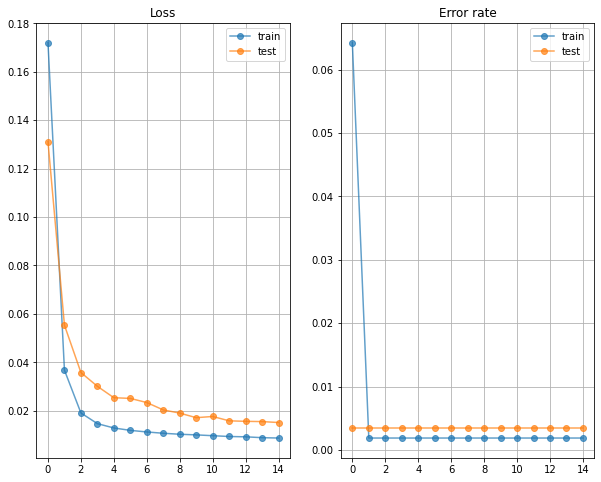

In [63]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.plot(train_losses, label='train', marker='o', alpha=0.7)
plt.plot(test_losses, label='test', marker='o', alpha=0.7)
plt.grid(True)
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(train_error_rates, label='train', marker='o', alpha=0.7)
plt.plot(test_error_rates, label='test', marker='o', alpha=0.7)
plt.grid(True)
plt.legend()
plt.title('Error rate')
plt.show()

should follow this format
https://colab.research.google.com/drive/1HtJpNyh6oWabiVcDUG_2TJ34TtVo5JH8?authuser=2#scrollTo=D2lKHjcfscif

In [ ]:
# compute Accuracy

In [88]:
# compute precision/recall rate
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,plot_roc_curve

def score_binary_classification(y_true, y_hat, report=True):
    """
    Create binary classification output
    :param y: true value
    :param y_hat: class 1 probabilities
    :param report:
    :return:
    """
    y_hat_class = [1 if x >= 0.5 else 0 for x in y_hat]  # convert probability to class for classification report

    report_string = "---Binary Classification Score--- \n"
    report_string += classification_report(y_true, y_hat_class)
    score = roc_auc_score(y_true, y_hat)
    report_string += "\nAUC = " + str(score)

    if report:
        print(report_string)

    return 

In [86]:
y_true = [0,0,0,1,1,1,1,1,1,1]
y_hat = [0.6,0.5,0.4,0.3,0.7,0.8,0.2,0.6,0.5,0.3]
score_binary_classification(y_true,y_hat,True)

---Binary Classification Score--- 
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.67      0.57      0.62         7

    accuracy                           0.50        10
   macro avg       0.46      0.45      0.45        10
weighted avg       0.54      0.50      0.52        10

AUC = 0.47619047619047616


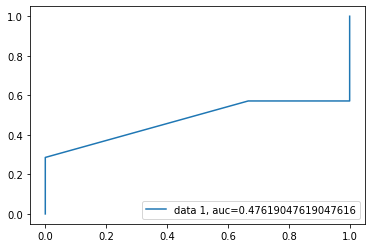

In [87]:
#import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
'''
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
'''
#import scikitplot as skplt
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
auc = roc_auc_score(y_true, y_hat)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()